In [1]:
# Verify required packages are available
import sys
print(f"Python version: {sys.version}")

try:
    import numpy as np
    print(f"✓ numpy {np.__version__} is available")
except ImportError as e:
    print(f"✗ numpy not available: {e}")

try:
    import matplotlib.pyplot as plt
    print("✓ matplotlib is available")
except ImportError as e:
    print(f"✗ matplotlib not available: {e}")

print("All required packages are ready!")

Python version: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.6.3.2)]
✓ numpy 2.4.1 is available
✓ matplotlib is available
All required packages are ready!


In [3]:
"""Uniform Cost Search (UCS) pathfinding for the warehouse grid."""
from __future__ import annotations
from dataclasses import dataclass
from heapq import heappop, heappush
from typing import Dict, Iterable, List, Optional, Tuple
Position = Tuple[int, int]
@dataclass(frozen=True)
class SearchResult:
    path: List[Position]
    cost: int
    nodes_expanded: int
    frontier_max: int
    time_sec: float
    expanded_order: List[Position]
def _neighbors(grid: List[str], pos: Position) -> Iterable[Position]:
    r, c = pos
    for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        nr, nc = r + dr, c + dc
        if nr < 0 or nc < 0 or nr >= len(grid) or nc >= len(grid[0]):
            continue
        if grid[nr][nc] != "#":
            yield (nr, nc)
def _reconstruct(came_from: Dict[Position, Optional[Position]], goal: Position) -> List[Position]:
    path = [goal]
    current = goal
    while came_from[current] is not None:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path
def ucs_path(
    grid: List[str],
    start: Position,
    goal: Position,
    record_expansions: bool = False,
) -> SearchResult:
    """Compute the lowest-cost path on a grid using UCS (Dijkstra).
    Cost per move is 1. Walls are '#'. Returns path + search statistics.
    """
    import time
    start_time = time.perf_counter()
    # frontier is a min-heap of (path_cost, tie_breaker, position)
    frontier: List[Tuple[int, int, Position]] = []
    heappush(frontier, (0, 0, start))
    # came_from lets us reconstruct the path at the end
    came_from: Dict[Position, Optional[Position]] = {start: None}
    # cost_so_far stores the best known cost to each position
    cost_so_far: Dict[Position, int] = {start: 0}
    nodes_expanded = 0
    frontier_max = 1
    tie = 0
    expanded_order: List[Position] = []
    while frontier:
        # Always expand the cheapest path so far
        cost, _, current = heappop(frontier)
        nodes_expanded += 1
        if record_expansions:
            expanded_order.append(current)
        # Goal test: stop once we pop the goal from the frontier
        if current == goal:
            path = _reconstruct(came_from, goal)
            return SearchResult(
                path=path,
                cost=cost,
                nodes_expanded=nodes_expanded,
                frontier_max=frontier_max,
                time_sec=time.perf_counter() - start_time,
                expanded_order=expanded_order,
            )
        # Explore neighbors (up, down, left, right) and relax edges
        for nxt in _neighbors(grid, current):
            new_cost = cost_so_far[current] + 1  # each move costs 1
            # If this is a better path to nxt, record it and push to frontier
            if nxt not in cost_so_far or new_cost < cost_so_far[nxt]:
                cost_so_far[nxt] = new_cost
                came_from[nxt] = current
                tie += 1  # ensures heap order is stable when costs tie
                heappush(frontier, (new_cost, tie, nxt))
                if len(frontier) > frontier_max:
                    frontier_max = len(frontier)
    return SearchResult(
        path=[],
        cost=float("inf"),
        nodes_expanded=nodes_expanded,
        frontier_max=frontier_max,
        time_sec=time.perf_counter() - start_time,
        expanded_order=expanded_order,
    )
if __name__ == "__main__":
    # Simple smoke test on the default warehouse grid.
    from warehouse_env import WarehouseEnv
    env = WarehouseEnv()
    obs = env.reset(randomize=False)
    start = obs["robot_pos"]
    pickup = obs["pickup_pos"]
    if pickup is None:
        raise RuntimeError("No pickup tile found in grid.")
    result = ucs_path(env.grid, start, pickup)
    print("UCS path length:", len(result.path) - 1)
    print("Nodes expanded:", result.nodes_expanded)

UCS path length: 2
Nodes expanded: 6


In [4]:
"""A* pathfinding for the warehouse grid."""
from __future__ import annotations
from dataclasses import dataclass
from heapq import heappop, heappush
from typing import Dict, Iterable, List, Optional, Tuple
Position = Tuple[int, int]
@dataclass(frozen=True)
class SearchResult:
    path: List[Position]
    cost: int
    nodes_expanded: int
    frontier_max: int
    time_sec: float
    expanded_order: List[Position]
def manhattan(a: Position, b: Position) -> int:
    return abs(a[0] - b[0]) + abs(a[1] - b[1])
def _neighbors(grid: List[str], pos: Position) -> Iterable[Position]:
    r, c = pos
    for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        nr, nc = r + dr, c + dc
        if nr < 0 or nc < 0 or nr >= len(grid) or nc >= len(grid[0]):
            continue
        if grid[nr][nc] != "#":
            yield (nr, nc)
def _reconstruct(came_from: Dict[Position, Optional[Position]], goal: Position) -> List[Position]:
    path = [goal]
    current = goal
    while came_from[current] is not None:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path
def astar_path(
    grid: List[str],
    start: Position,
    goal: Position,
    record_expansions: bool = False,
) -> SearchResult:
    """Compute a path on a grid using A* with Manhattan heuristic."""
    import time
    start_time = time.perf_counter()
    # frontier is a min-heap of (priority=f, path_cost=g, tie_breaker, position)
    frontier: List[Tuple[int, int, int, Position]] = []
    heappush(frontier, (manhattan(start, goal), 0, 0, start))
    # came_from lets us reconstruct the path at the end
    came_from: Dict[Position, Optional[Position]] = {start: None}
    # cost_so_far stores the best known g(n) to each position
    cost_so_far: Dict[Position, int] = {start: 0}
    nodes_expanded = 0
    frontier_max = 1
    tie = 0
    expanded_order: List[Position] = []
    while frontier:
        # Always expand the lowest f(n) = g(n) + h(n)
        _, cost, _, current = heappop(frontier)
        nodes_expanded += 1
        if record_expansions:
            expanded_order.append(current)
        # Goal test: stop once we pop the goal from the frontier
        if current == goal:
            path = _reconstruct(came_from, goal)
            return SearchResult(
                path=path,
                cost=cost,
                nodes_expanded=nodes_expanded,
                frontier_max=frontier_max,
                time_sec=time.perf_counter() - start_time,
                expanded_order=expanded_order,
            )
        # Explore neighbors (up, down, left, right) and relax edges
        for nxt in _neighbors(grid, current):
            new_cost = cost_so_far[current] + 1  # g(n) + cost of one step
            # If this is a better path to nxt, record it and push to frontier
            if nxt not in cost_so_far or new_cost < cost_so_far[nxt]:
                cost_so_far[nxt] = new_cost
                came_from[nxt] = current
                tie += 1  # ensures heap order is stable when priorities tie
                priority = new_cost + manhattan(nxt, goal)  # f(n) = g(n) + h(n)
                heappush(frontier, (priority, new_cost, tie, nxt))
                if len(frontier) > frontier_max:
                    frontier_max = len(frontier)
    return SearchResult(
        path=[],
        cost=float("inf"),
        nodes_expanded=nodes_expanded,
        frontier_max=frontier_max,
        time_sec=time.perf_counter() - start_time,
        expanded_order=expanded_order,
    )
if __name__ == "__main__":
    from warehouse_env import WarehouseEnv
    env = WarehouseEnv()
    obs = env.reset(randomize=False)
    start = obs["robot_pos"]
    pickup = obs["pickup_pos"]
    if pickup is None:
        raise RuntimeError("No pickup tile found in grid.")
    result = astar_path(env.grid, start, pickup)
    print("A* path length:", len(result.path) - 1)
    print("Nodes expanded:", result.nodes_expanded)

A* path length: 2
Nodes expanded: 3


In [6]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np

# Import warehouse environment and visualization
from warehouse_env import WarehouseEnv
from warehouse_viz import replay_animation

@dataclass
class TrialStats:
    path_len: int
    nodes_expanded: int
    frontier_max: int
    time_sec: float

# Use the SearchResult classes from the previous cells
# Note: Both UCS and A* have the same SearchResult structure, so we can use either
SearchResult = type(ucs_path([], (0, 0), (0, 0)))

In [7]:
#Run a single search segment
#Execute either UCS or A* on a path from start to goal.

def _run_segment(
    grid: List[str],
    start: Tuple[int, int],
    goal: Tuple[int, int],
    algo: str,
) -> SearchResult:
    if algo == "ucs":
        return ucs_path(grid, start, goal)
    if algo == "astar":
        return astar_path(grid, start, goal)
    raise ValueError(f"Unknown algo: {algo}")

In [8]:
#Aggregate trial statistics
#Sum path lengths, node expansions, and timings across search segments.

def _aggregate(results: List[SearchResult]) -> TrialStats:
    path_len = sum(max(0, len(r.path) - 1) for r in results)
    nodes_expanded = sum(r.nodes_expanded for r in results)
    frontier_max = max((r.frontier_max for r in results), default=0)
    time_sec = sum(r.time_sec for r in results)
    return TrialStats(path_len, nodes_expanded, frontier_max, time_sec)

In [9]:
#Run multiple randomized trials
#Execute UCS and A* on 10 random warehouse layouts, measuring performance on start→pickup→dropoff paths.

def run_trials(num_trials: int = 10) -> Dict[str, List[TrialStats]]:
    env = WarehouseEnv()
    stats: Dict[str, List[TrialStats]] = {"ucs": [], "astar": []}

    for _ in range(num_trials):
        obs = env.reset(randomize=True)
        start = obs["robot_pos"]
        pickup = obs["pickup_pos"]
        dropoff = obs["dropoff_pos"]
        if pickup is None or dropoff is None:
            continue

        for algo in ["ucs", "astar"]:
            seg1 = _run_segment(env.grid, start, pickup, algo)
            seg2 = _run_segment(env.grid, pickup, dropoff, algo)
            stats[algo].append(_aggregate([seg1, seg2]))

    return stats

In [10]:
# Render grid frame
# Create a visual frame showing robot position and load state.

def _frame_from_grid(grid: List[str], pos: Tuple[int, int], loaded: bool) -> List[List[str]]:
    rows = [list(r) for r in grid]
    r, c = pos
    rows[r][c] = "r" if loaded else "R"

In [11]:
# Visualize a single UCS run
# Replay one complete mission (start → pickup → dropoff) as an animation with real battery and reward metrics

def visualize_sample() -> None:
    """Replay a single UCS run as an animation (start → pickup → dropoff)."""
    env = WarehouseEnv()
    obs = env.reset(randomize=True)
    start = obs["robot_pos"]
    pickup = obs["pickup_pos"]
    dropoff = obs["dropoff_pos"]
    if pickup is None or dropoff is None:
        return

    seg1 = ucs_path(env.grid, start, pickup)
    seg2 = ucs_path(env.grid, pickup, dropoff)

    frames: List[List[List[str]]] = [env.render_grid()]
    battery = [env.state.battery]
    rewards = [0.0]
    dist_pickup = [abs(start[0] - pickup[0]) + abs(start[1] - pickup[1])]
    dist_dropoff = [abs(start[0] - dropoff[0]) + abs(start[1] - dropoff[1])]

    def step_to(next_pos: Tuple[int, int]) -> None:
        r0, c0 = env.state.robot_pos
        r1, c1 = next_pos
        if (r1, c1) == (r0 - 1, c0):
            action = "N"
        elif (r1, c1) == (r0 + 1, c0):
            action = "S"
        elif (r1, c1) == (r0, c0 - 1):
            action = "W"
        elif (r1, c1) == (r0, c0 + 1):
            action = "E"
        else:
            raise ValueError(f"Non-adjacent step: {(r0, c0)} -> {(r1, c1)}")

        obs_step, reward, _, _, _ = env.step(action)
        frames.append(env.render_grid())
        battery.append(obs_step["battery"])
        rewards.append(reward)
        dist_pickup.append(abs(obs_step["robot_pos"][0] - pickup[0]) + abs(obs_step["robot_pos"][1] - pickup[1]))
        dist_dropoff.append(abs(obs_step["robot_pos"][0] - dropoff[0]) + abs(obs_step["robot_pos"][1] - dropoff[1]))

    for pos in seg1.path[1:]:
        step_to(pos)
    obs_step, reward, _, _, _ = env.step("PICK")
    frames.append(env.render_grid())
    battery.append(obs_step["battery"])
    rewards.append(reward)
    dist_pickup.append(abs(obs_step["robot_pos"][0] - pickup[0]) + abs(obs_step["robot_pos"][1] - pickup[1]))
    dist_dropoff.append(abs(obs_step["robot_pos"][0] - dropoff[0]) + abs(obs_step["robot_pos"][1] - dropoff[1]))

    for pos in seg2.path[1:]:
        step_to(pos)
    obs_step, reward, _, _, _ = env.step("DROP")
    frames.append(env.render_grid())
    battery.append(obs_step["battery"])
    rewards.append(reward)
    dist_pickup.append(abs(obs_step["robot_pos"][0] - pickup[0]) + abs(obs_step["robot_pos"][1] - pickup[1]))
    dist_dropoff.append(abs(obs_step["robot_pos"][0] - dropoff[0]) + abs(obs_step["robot_pos"][1] - dropoff[1]))

    metrics = {
        "battery": battery,
        "rewards": rewards,
        "dist_pickup": dist_pickup,
        "dist_dropoff": dist_dropoff,
    }

    anim = replay_animation(frames, metrics=metrics)
    if "autofig_gif" in globals():
        anim = autofig_gif(anim, caption="UCS delivery animation", label="anim-ucs-delivery", width="70%", fps=6)

In [12]:
# Build animation for a path pair
# Drive the environment through two paths (start→pickup, then pickup→dropoff) with PICK/DROP actions, capturing metrics per step.

def _build_animation(env: WarehouseEnv, path_a: List[Tuple[int, int]], path_b: List[Tuple[int, int]]) -> None:
    frames: List[List[List[str]]] = [env.render_grid()]
    battery = [env.state.battery]
    rewards = [0.0]
    pickup = path_a[-1]
    dropoff = path_b[-1]
    dist_pickup = [abs(env.state.robot_pos[0] - pickup[0]) + abs(env.state.robot_pos[1] - pickup[1])]
    dist_dropoff = [abs(env.state.robot_pos[0] - dropoff[0]) + abs(env.state.robot_pos[1] - dropoff[1])]

    def step_to(next_pos: Tuple[int, int]) -> None:
        r0, c0 = env.state.robot_pos
        r1, c1 = next_pos
        if (r1, c1) == (r0 - 1, c0):
            action = "N"
        elif (r1, c1) == (r0 + 1, c0):
            action = "S"
        elif (r1, c1) == (r0, c0 - 1):
            action = "W"
        elif (r1, c1) == (r0, c0 + 1):
            action = "E"
        else:
            raise ValueError(f"Non-adjacent step: {(r0, c0)} -> {(r1, c1)}")

        obs_step, reward, _, _, _ = env.step(action)
        frames.append(env.render_grid())
        battery.append(obs_step["battery"])
        rewards.append(reward)
        dist_pickup.append(abs(obs_step["robot_pos"][0] - pickup[0]) + abs(obs_step["robot_pos"][1] - pickup[1]))
        dist_dropoff.append(abs(obs_step["robot_pos"][0] - dropoff[0]) + abs(obs_step["robot_pos"][1] - dropoff[1]))

    for pos in path_a[1:]:
        step_to(pos)
    obs_step, reward, _, _, _ = env.step("PICK")
    frames.append(env.render_grid())
    battery.append(obs_step["battery"])
    rewards.append(reward)
    dist_pickup.append(abs(obs_step["robot_pos"][0] - pickup[0]) + abs(obs_step["robot_pos"][1] - pickup[1]))
    dist_dropoff.append(abs(obs_step["robot_pos"][0] - dropoff[0]) + abs(obs_step["robot_pos"][1] - dropoff[1]))

    for pos in path_b[1:]:
        step_to(pos)
    obs_step, reward, _, _, _ = env.step("DROP")
    frames.append(env.render_grid())
    battery.append(obs_step["battery"])
    rewards.append(reward)
    dist_pickup.append(abs(obs_step["robot_pos"][0] - pickup[0]) + abs(obs_step["robot_pos"][1] - pickup[1]))
    dist_dropoff.append(abs(obs_step["robot_pos"][0] - dropoff[0]) + abs(obs_step["robot_pos"][1] - dropoff[1]))

    metrics = {
        "battery": battery,
        "rewards": rewards,
        "dist_pickup": dist_pickup,
        "dist_dropoff": dist_dropoff,
    }

    anim = replay_animation(frames, metrics=metrics)
    if "autofig_gif" in globals():
        anim = autofig_gif(anim, caption="Warehouse delivery animation", label="anim-warehouse-delivery", width="70%", fps=6)


In [13]:
# Side-by-side UCS vs A* example
# Run both algorithms on the same layout, show their expansion heatmaps and paths, then replay both animations.

def example_ucs_then_astar() -> None:
    """Run a single UCS example, then a single A* example, on the same layout."""
    env = WarehouseEnv()
    obs = env.reset(randomize=True)
    start = obs["robot_pos"]
    pickup = obs["pickup_pos"]
    dropoff = obs["dropoff_pos"]
    if pickup is None or dropoff is None:
        return

    ucs_seg1 = ucs_path(env.grid, start, pickup, record_expansions=True)
    ucs_seg2 = ucs_path(env.grid, pickup, dropoff, record_expansions=True)
    print("\nUCS example path length:", (len(ucs_seg1.path) - 1) + (len(ucs_seg2.path) - 1))
    _build_animation(WarehouseEnv(grid=env.grid, start_pos=start), ucs_seg1.path, ucs_seg2.path)

    astar_seg1 = astar_path(env.grid, start, pickup, record_expansions=True)
    astar_seg2 = astar_path(env.grid, pickup, dropoff, record_expansions=True)
    print("A* example path length:", (len(astar_seg1.path) - 1) + (len(astar_seg2.path) - 1))
    _build_animation(WarehouseEnv(grid=env.grid, start_pos=start), astar_seg1.path, astar_seg2.path)

    plot_expansion_maps(
        env.grid,
        ucs_seg1.expanded_order + ucs_seg2.expanded_order,
        astar_seg1.expanded_order + astar_seg2.expanded_order,
        start,
        pickup,
        dropoff,
        ucs_seg1.path + ucs_seg2.path[1:],
        astar_seg1.path + astar_seg2.path[1:],
    )

In [14]:
# Plot side-by-side expansion heatmaps
# Visualize where UCS and A* explored the search space, overlaying the path each algorithm found.

def plot_expansion_maps(
    grid: List[str],
    ucs_expanded: List[Tuple[int, int]],
    astar_expanded: List[Tuple[int, int]],
    start: Tuple[int, int],
    pickup: Tuple[int, int],
    dropoff: Tuple[int, int],
    ucs_path: List[Tuple[int, int]],
    astar_path: List[Tuple[int, int]],
) -> None:
    """Show where UCS vs A* expanded nodes on the same layout."""
    height = len(grid)
    width = len(grid[0]) if grid else 0

    def counts(expanded: List[Tuple[int, int]]) -> np.ndarray:
        heat = np.zeros((height, width), dtype=float)
        for r, c in expanded:
            heat[r, c] += 1.0
        return heat

    wall_mask = np.array([[1 if ch == "#" else 0 for ch in row] for row in grid])
    ucs_heat = counts(ucs_expanded)
    astar_heat = counts(astar_expanded)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    legend_handles = None
    last_im = None
    for ax, heat, title, path in zip(
        axes,
        [ucs_heat, astar_heat],
        ["UCS Expansions", "A* Expansions"],
        [ucs_path, astar_path],
    ):
        ax.imshow(wall_mask, cmap="gray", alpha=0.25)
        im = ax.imshow(heat, cmap="magma", alpha=0.85)
        last_im = im
        if path:
            ys = [p[0] for p in path]
            xs = [p[1] for p in path]
            line = ax.plot(xs, ys, color="cyan", linewidth=2.0, alpha=0.9, label="Path")[0]
        else:
            line = ax.plot([], [], color="cyan", linewidth=2.0, alpha=0.9, label="Path")[0]
        start_handle = ax.scatter(start[1], start[0], s=60, c="#2ca02c", marker="o", label="Start")
        pickup_handle = ax.scatter(pickup[1], pickup[0], s=70, c="#1f77b4", marker="s", label="Pickup")
        dropoff_handle = ax.scatter(dropoff[1], dropoff[0], s=70, c="#d62728", marker="X", label="Dropoff")
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        if legend_handles is None:
            legend_handles = [line, start_handle, pickup_handle, dropoff_handle]

    if last_im is not None:
        fig.colorbar(last_im, ax=axes, fraction=0.046, pad=0.04)

    if legend_handles:
        fig.legend(
            handles=legend_handles,
            labels=["Path", "Start", "Pickup", "Dropoff"],
            loc="upper center",
            bbox_to_anchor=(0.5, 1.02),
            frameon=False,
            fontsize=8,
            ncol=4,
        )

    fig.subplots_adjust(top=0.85, right=0.88)
    plt.show()

In [15]:
# Print summary statistics
# Display mean path length, node expansions, frontier size, and wall-clock time for UCS vs A* across all trials.

def summary_table(stats: Dict[str, List[TrialStats]]) -> None:
    def arr(algo: str, attr: str) -> np.ndarray:
        return np.array([getattr(s, attr) for s in stats[algo]])

    rows = []
    for algo in ["ucs", "astar"]:
        mean_time_ms = arr(algo, "time_sec").mean() * 1000.0
        rows.append(
            [
                algo.upper(),
                arr(algo, "path_len").mean(),
                arr(algo, "nodes_expanded").mean(),
                arr(algo, "frontier_max").mean(),
                mean_time_ms,
            ]
        )

    headers = ["Algorithm", "Mean Path Len", "Mean Nodes", "Mean Frontier", "Mean Time (ms)"]
    print("\nSummary (10 trials):")
    print("{:<10} {:>14} {:>12} {:>14} {:>14}".format(*headers))
    for row in rows:
        print(
            "{:<10} {:>14.2f} {:>12.2f} {:>14.2f} {:>14.2f}".format(
                row[0], row[1], row[2], row[3], row[4]
            )
        )

In [16]:
# Bar chart: nodes expanded
# Compare mean node expansions between UCS and A*.

def plot_nodes(stats: Dict[str, List[TrialStats]]) -> None:
    means = [
        np.mean([s.nodes_expanded for s in stats["ucs"]]),
        np.mean([s.nodes_expanded for s in stats["astar"]]),
    ]
    labels = ["UCS", "A*"]
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, means, color=["#4e79a7", "#f28e2b"])
    plt.ylabel("Mean Nodes Expanded")
    plt.title("UCS vs A* (10 Random Trials)")
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{bar.get_height():.1f}", ha="center")
    plt.tight_layout()
    plt.show()


Summary (10 trials):
Algorithm   Mean Path Len   Mean Nodes  Mean Frontier Mean Time (ms)
UCS                 12.00        49.30           8.20           0.08
ASTAR               12.00        23.50           8.70           0.04


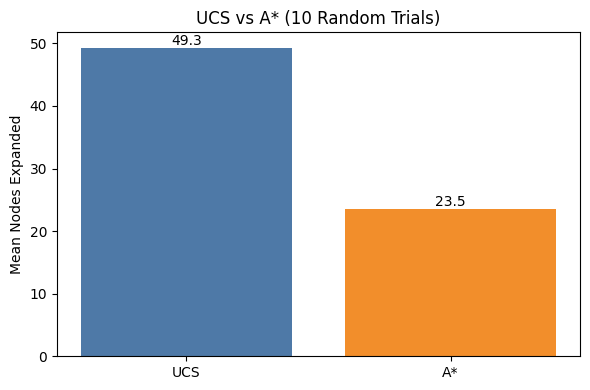

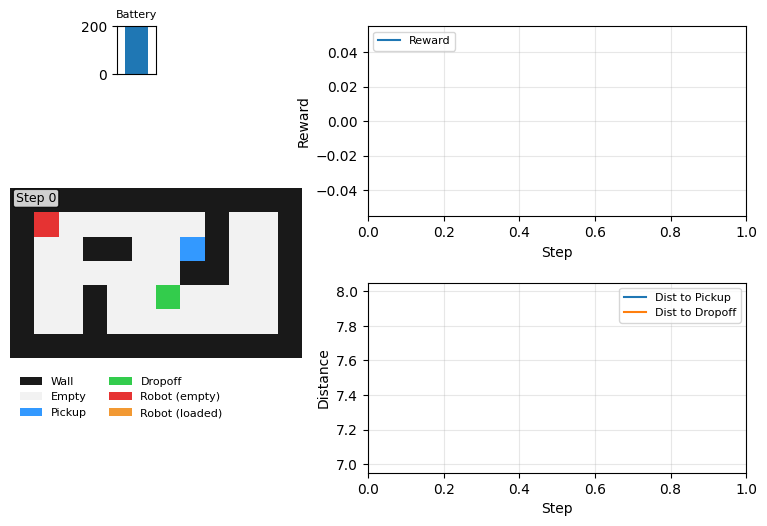


UCS example path length: 9


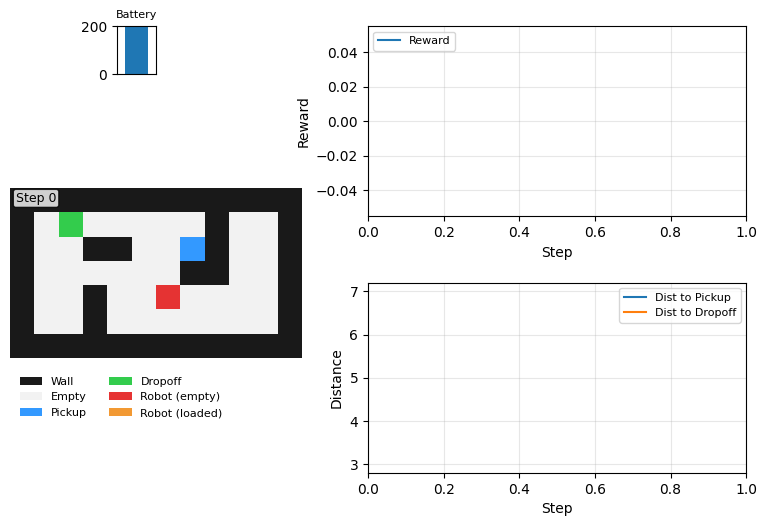

A* example path length: 9


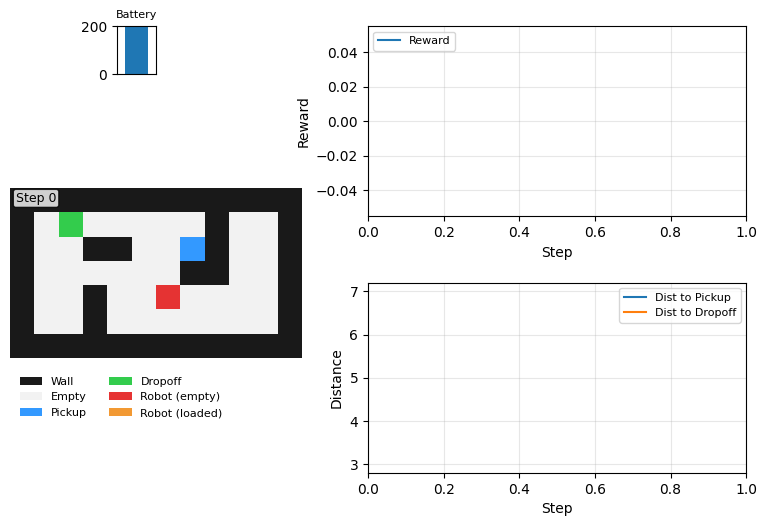

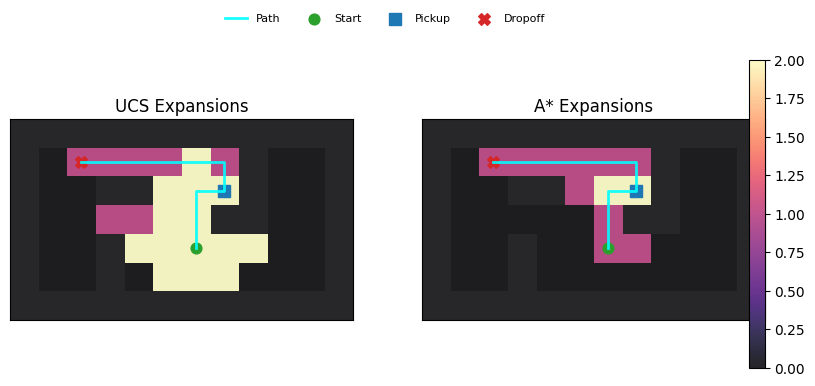

In [17]:
# Run the Full Comparison
# Execute 10 randomized trials comparing UCS and A* on warehouse routing tasks.

stats = run_trials(num_trials=10)

# Display summary statistics. Print a table showing mean performance metrics for both algorithms.
summary_table(stats)

# Visualize node expansion comparison. Bar chart comparing mean nodes expanded between UCS and A*.
plot_nodes(stats)

# Sample UCS trajectory. Animate a single warehouse delivery using UCS pathfinding.
visualize_sample()

# Side-by-side algorithm comparison. Run both UCS and A* on the same layout, showing expansion heatmaps and animated trajectories.
example_ucs_then_astar()
